In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import RFE
import os

### Reading clean data

In [4]:
dspaths = []

def read_paths(dir_path):
  for dirname, _, filenames in os.walk(dir_path):
      for filename in filenames:
          if filename.endswith('.parquet'):
              pds = os.path.join(dirname, filename)
              dspaths.append(pds)
              print(pds)
  return dspaths

def read_files(dspaths):
    individual_dfs = [pd.read_parquet(dsp) for dsp in dspaths]
    return individual_dfs

In [6]:
dspaths = read_paths('../IDS2017/Clean')
dfs = read_files(dspaths)

data = pd.concat(dfs, ignore_index=True)

../IDS2017/Clean/Combined.parquet
../IDS2017/Clean/Friday-WorkingHours-Afternoon-DDos.parquet
../IDS2017/Clean/Friday-WorkingHours-Afternoon-PortScan.parquet
../IDS2017/Clean/Friday-WorkingHours-Morning.parquet
../IDS2017/Clean/Monday-WorkingHours.parquet
../IDS2017/Clean/Thursday-WorkingHours-Afternoon-Infilteration.parquet
../IDS2017/Clean/Thursday-WorkingHours-Morning-WebAttacks.parquet
../IDS2017/Clean/Tuesday-WorkingHours.parquet
../IDS2017/Clean/Wednesday-workingHours.parquet


In [9]:
data[" Label"].value_counts()

 Label
BENIGN                        9085280
DoS Hulk                       920496
PortScan                       635216
DDoS                           512100
DoS GoldenEye                   41172
FTP-Patator                     31740
SSH-Patator                     23588
DoS slowloris                   23184
DoS Slowhttptest                21996
Bot                              7824
Web Attack � Brute Force         6028
Web Attack � XSS                 2608
Infiltration                      144
Web Attack � Sql Injection         84
Heartbleed                         44
Name: count, dtype: int64

<Axes: xlabel=' Label'>

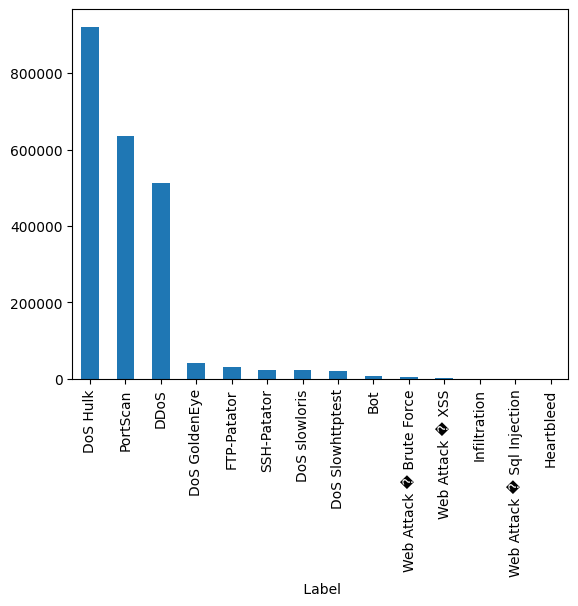

In [11]:
data[data[" Label"] != "BENIGN"][" Label"].value_counts().plot(kind='bar')

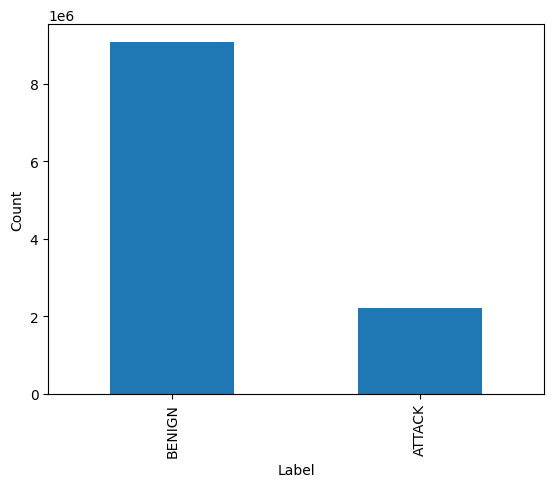

In [15]:
label_counts = data[" Label"].value_counts()
summary_counts = pd.Series({
    "BENIGN": label_counts["BENIGN"],
    "ATTACK": label_counts.drop("BENIGN").sum()
})
summary_counts.plot(kind='bar')

plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Splitting the dataset (train/test)

In [1]:
X = data.drop(' Label', axis=1)
y = data[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'data' is not defined

### Feature importance evaluation using Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
importances = rf.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(15))


                         Feature  Importance
41             Packet Length Std    0.058303
42        Packet Length Variance    0.057518
39             Max Packet Length    0.048451
63             Subflow Fwd Bytes    0.048158
54          Avg Bwd Segment Size    0.046707
0               Destination Port    0.043021
52           Average Packet Size    0.038201
10         Bwd Packet Length Max    0.035765
13         Bwd Packet Length Std    0.033369
66        Init_Win_bytes_forward    0.030732
5    Total Length of Bwd Packets    0.030708
4    Total Length of Fwd Packets    0.029861
65             Subflow Bwd Bytes    0.028291
40            Packet Length Mean    0.024266
12        Bwd Packet Length Mean    0.023383


In [24]:
mean_importance = feature_importances['Importance'].mean()

important_features = feature_importances[feature_importances['Importance'] > mean_importance]
important_feature_names = important_features['Feature'].tolist()

X_important = X[important_feature_names]

print(important_feature_names)

[' Packet Length Std', ' Packet Length Variance', ' Max Packet Length', ' Subflow Fwd Bytes', ' Avg Bwd Segment Size', ' Destination Port', ' Average Packet Size', 'Bwd Packet Length Max', ' Bwd Packet Length Std', 'Init_Win_bytes_forward', ' Total Length of Bwd Packets', 'Total Length of Fwd Packets', ' Subflow Bwd Bytes', ' Packet Length Mean', ' Bwd Packet Length Mean', ' Fwd Packet Length Mean', ' Fwd Packet Length Max', ' Avg Fwd Segment Size', ' Fwd Header Length', ' Bwd Header Length', ' Init_Win_bytes_backward', ' Fwd Header Length.1', ' PSH Flag Count', ' Bwd Packets/s', 'Flow Bytes/s']


### Feature importance evaluation using Recursive Feature Elimination
RFE + Random Forest, a more efficient method, but it requires more resources. Random Forest Classifier must be calculated before running RFE.

In [26]:
features_n = 10

selector = RFE(rf, n_features_to_select = features_n, step=1)
selector = selector.fit(X_train, y_train)

selected_features = X.columns[selector.support_]
print(selected_features)

### Trimming columns according to importance

In [18]:
selected_features = [
    'Label', ' Destination Port', ' Total Length of Bwd Packets', ' Total Length of Fwd Packets',
    ' Subflow Fwd Bytes', ' Avg Bwd Segment Size', ' Average Packet Size', ' Bwd Packet Length Max',
    ' Bwd Packet Length Std', ' Init_Win_bytes_forward', ' Packet Length Mean', ' Packet Length Std',
    ' Packet Length Variance', ' Max Packet Length'
]

new_data = data[selected_features]
data.columns = data.columns.str.lstrip()
print(new_data.sample())

new_data.to_parquet("../IDS2017/Final/Combined.parquet", index=False)

         Label  Total Length of Fwd Packets   Total Length of Bwd Packets  \
487728  BENIGN                           64                            96   

        Bwd Packet Length Max   Bwd Packet Length Mean  \
487728                     48                     48.0   

         Bwd Packet Length Std   Average Packet Size   Avg Bwd Segment Size  \
487728                     0.0                  48.0                   48.0   

         Fwd Header Length.1   Subflow Fwd Bytes   Subflow Bwd Bytes  
487728                    40                  64                  96  
